![logo](https://climate.copernicus.eu/sites/default/files/2025-03/logoline_c3s.png)

# Analyzing Ocean Colour and Sea Surface Temperature during El Niño and La Niña Events

**This notebook can be run on free online platforms, such as Binder, Kaggle and Colab, or they can be accessed from GitHub. The links to run this notebook in these environments are provided here, but please note they are not supported by ECMWF.**

[![binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/ecmwf-training/c3s-training-submodule-sat-obs-ocean/develop?labpath=ocean-colour-sea-surface-temperature.ipynb)
[![kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-training/c3s-training-submodule-sat-obs-ocean/blob/develop/ocean-colour-sea-surface-temperature.ipynb)
[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ecmwf-training/c3s-training-submodule-sat-obs-ocean/blob/develop/ocean-colour-sea-surface-temperature.ipynb)
[![github](https://img.shields.io/badge/Open%20in-GitHub-black?logo=github)](https://github.com/ecmwf-training/c3s-training-submodule-sat-obs-ocean/blob/develop/ocean-colour-sea-surface-temperature.ipynb)

## Introduction

This tutorial provides a practical introduction to daily **Ocean Colour (OC)** data (available from 1997 onwards) and **Sea Surface Temperature (SST)** data (available from 1981 to 2016), both derived from satellite observations of the global ocean.

These datasets are freely accessible from the Climate Data Store (CDS) with a registered account.

In this example, we will use the variable `mass chlorophyll-a per unit volume of near-surface water` (mg m⁻³) from the OC dataset and the `Analysed SST` (K) from the SST dataset to compare **December values** during an **El Niño (2015)** year, a **La Niña (1999)** year, and a **neutral (2013)** year in the equatorial Pacific.

**Sea Surface Temperature** and **Chlorophyll-a concentration** are key indicators of oceanic conditions and are closely associated with El Niño and La Niña events. The gridded datasets from CDS support the examination of oceanic changes on different spatial scales on a daily basis and are available globally for both OC and SST.

## Learning objectives 🎯

In this tutorial notebook, you will:
1. Learn how to **subset and download** OC and SST datasets from CDS for December 1999, 2013 and 2015.
2. Examine the daily datasets downloaded
3. Extract daily `chl_a` and `analysed_SST` data to visualise **daily time series** for each variable comparing of all three years.
4. Aggregate the daily data to **monthly** NetCDF files.
5. Visualise monthly averaged values as maps to examine spatial change in distribution of `chl_a` and `analysed_SST`.
6. Calculate **anomalies** in December during El Niña and La Niña years compared to a "neutral" year and plot them in maps.

## Prepare your environment

The first thing we need to do, is make sure you are ready to run the code while working through this notebook. There are some simple steps you need to do to get yourself set up.

### Set up CDSAPI and your credentials

The code below will ensure that the `cdsapi` package is installed. If you have not setup your `~/.cdsapirc` file with your credentials, you can replace `None` with your credentials that can be found on the [how to api](https://cds.climate.copernicus.eu/how-to-api) page (you will need to log in to see your credentials).

In [1]:
!pip install -q cdsapi
# If you have already setup your .cdsapirc file you can leave this as None
cdsapi_key = None
cdsapi_url = None

### (Install and) Import libraries

This tutorial is written in **Python** and requires basic Python knowledge and an environment that includes the following Python libraries:

| Library   | Purpose |
|-----------|---------|
| **[cdsapi](https://pypi.org/project/cdsapi/)**  | Access and download data from the Copernicus Climate Data Store |
| **[os](https://docs.python.org/3/library/os.html)**  | Handle file and directory operations |
| **[zipfile](https://docs.python.org/3/library/zipfile.html)**  | Extract and manage ZIP archive files |
| **[xarray](https://xarray.dev/)**  | Work with multi-dimensional labeled datasets, commonly used for NetCDF files (format of OC and SST data from CDS) |
| **[netCDF4](https://unidata.github.io/netcdf4-python/)** | Read and write NetCDF files directly |
| **[dask](https://www.dask.org/)** | Enable parallel computing and efficient handling of large datasets with xarray |
| **[glob](https://docs.python.org/3/library/glob.html)**  | Search for file paths using pattern matching |
| **[cartopy](https://scitools.org.uk/cartopy/docs/latest/)**  | Create maps and visualize geospatial data |
| **[matplotlib](https://matplotlib.org/stable/index.html)**  | Generate plots, charts, and visualizations |

In [2]:
import cdsapi
import os
import sys
import zipfile

import xarray as xr
import netCDF4
import dask
import glob

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import FuncFormatter

### Specify data directory

In [3]:
# Directory to store data
# Please ensure that data_dir is a location where you have write permissions
DATADIR = './data_dir/'
# Create this directory if it doesn't exist
os.makedirs(DATADIR, exist_ok=True)

### Define subset area and years

In this tutorial, we will exploratively analyze two specific events (El Niño and La Niña) in an area of interest (the equatorial Pacific) and compare the results to a 'neutral' year to understand their impact on oceanic conditions. <br>

To do this, we will define the `years` and `area` for data download here:

In [4]:
# Define the years
# Here: 1999 La Nina; 2013 Neutral; 2015 El Nino
years = [1999, 2013, 2015]

# Define the region of interest
# Here: Pacific Ocean near South America to observe El Nino and La Nina events
# area = [North, West, South, East]
area = [20, -160, -20, -80]

## Explore data

This notebook uses two Essential Climate Variable (ECV) datasets derived from satellite observations, and which are freely available through the **Copernicus Climate Data Store**:

1. **Ocean Colour (Chlorophyll-a concentration)**
   - **Variable**: `mass chlorophyll-a per unit volume of near-surface water`
   - **Temporal coverage**: Daily
   - **Units**: mg/m³ - Mass chlorophyll-a per unit of volume of near-surface water.
   - **Definition**: Chlorophyll-a (Chl-a) is the main photosynthetic pigment found in phytoplankton, which form the base of the marine food-web and are responsible for approximately half of global photosynthesis.
   - **ECV importance**: Ocean colour plays an essential role in our ability to monitor the health and productivity of marine ecosystems, assess the role of the oceans in the global carbon cycle, and quantify the impacts of climate change. 

2. **Sea Surface Temperature (SST)**
   - **Variable**: `Analysed SST`
   - **Temporal coverage**: Daily
   - **Units**: Kelvin (K) - Median of the 16 input SST analyses (one field).
   - **Definition**: SST represents the temperature of the ocean’s surface layer and is a fundamental parameter in climate and weather prediction.
   - **ECV importance**: SST influences air–sea interactions, weather patterns, ocean circulation, and marine ecosystems. It is a core parameter for climate monitoring.

**These two ECVs are closely linked**: sea surface temperature affects biological processes such as phytoplankton growth, while ocean colour (via chlorophyll-a) provides insight into those biological responses to changing physical conditions. Together, they provide a valuable picture of the ocean's role in the Earth system.

For detailed information on the datasets, please visit the CDS website:
__[Daily Ocean Colour](https://cds.climate.copernicus.eu/datasets/satellite-ocean-colour?tab=overview")__ & __[Daily Sea Surface Temperature](https://cds.climate.copernicus.eu/datasets/satellite-sea-surface-temperature-ensemble-product?tab=overview)__

### Download the data

There is a limit to how much data can be downloaded from the CDS at once. Since the OC and SST datasets are large, we will quickly reach this limit. You can check the limit manually by using the "Download" option on the dataset websites (right panel: "Request Validation": __[OC](https://cds.climate.copernicus.eu/datasets/satellite-ocean-colour?tab=download)__ & __[SST](https://cds.climate.copernicus.eu/datasets/satellite-sea-surface-temperature-ensemble-product?tab=download)__).  

To avoid downloading each dataset separately, we will automate the process by looping through each day, downloading and unzipping the data, and storing it locally.

The `OC` and `SST` data will be downloaded in a daily zip files containing a NetCDF file for each variable by default. We want to download the data, **unzip the daily NetCDF files** and **store them directly into monthly folders** for every year. 

Resulting in the following folder structure: 
- `data_cds_oc` --> `2015-12`, `2013-12` and `1999-12` (each containing 31 .nc files)
- `data_cds_sst` --> `2015-12`, `2013-12` and `1999-12` (each containing 31 .nc files)

:::{warning}

**Important Note:**  It will take approx. **30 mins to download OC data** and **30 mins to download SST data** for this tutorial's subset area and temporal selection of daily data for December 1999, 2013, and 2015. 

Please be aware that when selecting larger timeframes or areas, the download time could take even longer and could result in file sizes ≥ 1 GB.

:::

#### Download Daily Ocean Colour data

Now we are ready to request the data via the CDS API and download the daily OC data for December of 1999, 2013 and 2015.

The request is defined by the following key variables:
- Product: `satellite-ocean-colour`
- Variable: `mass_concentration_of_chlorophyll_a` in mg m-3
- Year: `as defined above`
- Month: `12` for December of each year
- Day: `Range 1-32` for each day of December
- Area: `as defined above`
- Version: `6_0` for the most up to date version

In [5]:
%%capture cap
# Initialize the CDS API client
client = cdsapi.Client()

data_dir_oc = f"{DATADIR}/oc/"
days = [f"{day:02d}" for day in range(1, 32)]
# Loop through each year
for year in years:
    # Create a subfolder for the year and month (e.g. 1999-12)
    year_month_folder = os.path.join(data_dir_oc, f"{year}-12")
    os.makedirs(year_month_folder, exist_ok=True)

    # Request data for the current day
    request = {
        "variable": ["mass_concentration_of_chlorophyll_a"],
        "projection": "regular_latitude_longitude_grid",
        "year": [str(year)],
        "month": ["12"],
        "day": days,
        "area": area,
        "version": "6_0"
    }

    download_path = os.path.join(
        year_month_folder, f"ocean_colour_{year}_12.nc.zip"
    )
    if not os.path.exists(download_path):
        print(f"Downloading data for {year}-12...", file=sys.__stdout__)
        client.retrieve(
            "satellite-ocean-colour",
            request,
            download_path,
        )
        # Unzip the downloaded file
        with zipfile.ZipFile(download_path, "r") as zip_ref:
            zip_ref.extractall(year_month_folder)
    else:
        print(f"Data for {year}-12 already exists. Skipping download.", file=sys.__stdout__)

    print(f"Data for {year}-12 successfully downloaded and unzipped!", file=sys.__stdout__)

print("All downloads are complete!", file=sys.__stdout__)

Data for 1999-12 successfully downloaded and unzipped!
Data for 2013-12 successfully downloaded and unzipped!
Data for 2015-12 successfully downloaded and unzipped!
All downloads are complete!


#### Download Daily Sea Surface Temperature data

Now we request the data to donwload the daily SST data for December of 1999, 2013 an 2015.

The request is defined by the following key variables:
- Product: `satellite-sea-surface-temperature`
- Variable: `analysed_sst` as median of the input analyses
- Processing Level: `Level 4`
- Sensor on Satellite: `Combined product`
- Version: `2_1` for the most up to date version
- Year: `as defined above`
- Month: `12` for December of each year
- Day: `Range 1-32` for each day of December
- Area: `as defined above`

In [6]:
%%capture cap
# Initialize the CDS API client
client = cdsapi.Client()

data_dir_sst = f"{DATADIR}/sst/"
days = [f"{day:02d}" for day in range(1, 32)]
# Loop through each year
for year in years:
    # Create a subfolder for the year and month (e.g. 1999-12)
    year_month_folder = os.path.join(data_dir_sst, f"{year}-12")
    os.makedirs(year_month_folder, exist_ok=True)
    
    # Request data for the current day with the specified area
    request = {
        "variable": "analysed_sst",
        "processinglevel": "level_4",
        "sensor_on_satellite": "combined_product",
        "version": "2_1",
        "year": [str(year)],
        "month": ["12"],
        "day": days,
        "area": area,
    }

    # Download data for the current day and store it in the corresponding folder
    download_path = os.path.join(
        year_month_folder, f"sst_{year}_12.nc.zip"
    )
    if not os.path.exists(download_path):
        print(f"Downloading data for {year}-12...", file=sys.__stdout__)
        client.retrieve(
            "satellite-sea-surface-temperature",
            request,
            download_path,
        )
        # Unzip the downloaded file
        with zipfile.ZipFile(download_path, "r") as zip_ref:
            zip_ref.extractall(year_month_folder)
    else:
        print(f"Data for {year}-12 already exists. Skipping download.", file=sys.__stdout__)

    print(f"Data for {year}-12 successfully downloaded and unzipped!", file=sys.__stdout__)

print("All downloads are complete!", file=sys.__stdout__)

Data for 1999-12 successfully downloaded and unzipped!
Data for 2013-12 successfully downloaded and unzipped!
Data for 2015-12 successfully downloaded and unzipped!
All downloads are complete!


### Inspect data

The daily `.nc` files have been downloaded and unzipped. NetCDF is a commonly used format for array-oriented scientific data. We use the `xarray` library to read and process this data.

We will read the data from our NetCDF file by choosing an example day and year from one of the datasets.

In [9]:
# Choose the data type ("oc" or "sst")
data_type = "oc"

# Set the year and day for the file search
# Year: 1999, 2013, 2015
# Day: 1-31
# Note: The month is fixed to December as we have downloaded data only for December data
year = 2013
day = "15"

# Define the base path based on the chosen data type
if data_type == "oc":
    base_path = f"{DATADIR}/oc/"
elif data_type == "sst":
    base_path = f"{DATADIR}/sst/"
else:
    raise ValueError("Invalid data type. Choose 'oc' or 'sst'.")

# Define the folder for the selected year
folder_path = f"{base_path}/{year}-12"

# Search for the file for the selected day
file_pattern = f"{folder_path}/*{day}*.nc"
files = glob.glob(file_pattern)

if not files:
    raise FileNotFoundError(f"No file found for {day} in {folder_path}.")

# Open the found file
ds = xr.open_dataset(files[0])

# Show the structure of the .nc file
ds

<xarray.Dataset> Size: 59MB
Dimensions:       (time: 1, lat: 960, lon: 1920)
Coordinates:
  * lat           (lat) float64 8kB 19.98 19.94 19.9 ... -19.9 -19.94 -19.98
  * lon           (lon) float64 15kB -160.0 -159.9 -159.9 ... -80.06 -80.02
  * time          (time) datetime64[ns] 8B 2013-12-15
Data variables:
    MERIS_nobs    (time, lat, lon) float32 7MB ...
    MODISA_nobs   (time, lat, lon) float32 7MB ...
    OLCI-A_nobs   (time, lat, lon) float32 7MB ...
    OLCI-B_nobs   (time, lat, lon) float32 7MB ...
    SeaWiFS_nobs  (time, lat, lon) float32 7MB ...
    VIIRS_nobs    (time, lat, lon) float32 7MB ...
    chlor_a       (time, lat, lon) float32 7MB ...
    crs           int32 4B ...
    total_nobs    (time, lat, lon) float32 7MB ...
Attributes: (12/45)
    Conventions:                    CF-1.7
    Metadata_Conventions:           Unidata Dataset Discovery v1.0
    cdm_data_type:                  Grid
    comment:                        See summary attribute
    creation_date:                  20220518T150831Z
    creator_email:                  help@esa-oceancolour-cci.org
    ...                             ...
    time_coverage_start:            201312150000Z
    title:                          Copernicus Climate Change Service Ocean C...
    tracking_id:                    5076b880-26e6-471d-b9a0-696354571a24
    NCO:                            netCDF Operators version 4.7.5 (Homepage ...
    id:                             ESACCI-OC-L3S-CHLOR_A-MERGED-1D_DAILY_4km...
    summary:                        Data products generated for C3S using the...

We see that the `OC` dataset has multiple variables. Here, we are interested in the `chlor_a` as a proxy for phytoplankton biomass, the base of the ocean food web, and sensitive to changes in ocean conditions caused by ENSO events such as El Niño or La Niña.

For the `SST` dataset, we have already selected the `analysed_SST` variable in the download request. SST is one of the core indicators and drivers of El Niño and La Niña events.

Additionally, the dataset includes geographic coordinates (**latitude** and **longitude**) and **time**, along with the product's **metadata** (e.g. data type, creator, title, etc.). While these coordinates are conceptually independent dimensions, the data itself is stored in a **three-dimensional array** with dimensions `(time, latitude, longitude)`. This structure allows us to explore how the variable of interest (e.g. chlorophyll-a concentration or sea surface temperature) changes over space *and* time.


We can visualize one time step (selected from above) to figure out what the data look like on the daily basis. Xarray offers built-in matplotlib functions that allow you to plot a `DataArray`. With the function `plot()`, you can easily plot, for example, the first time step of the loaded array for `chlor_a` or any other variable.

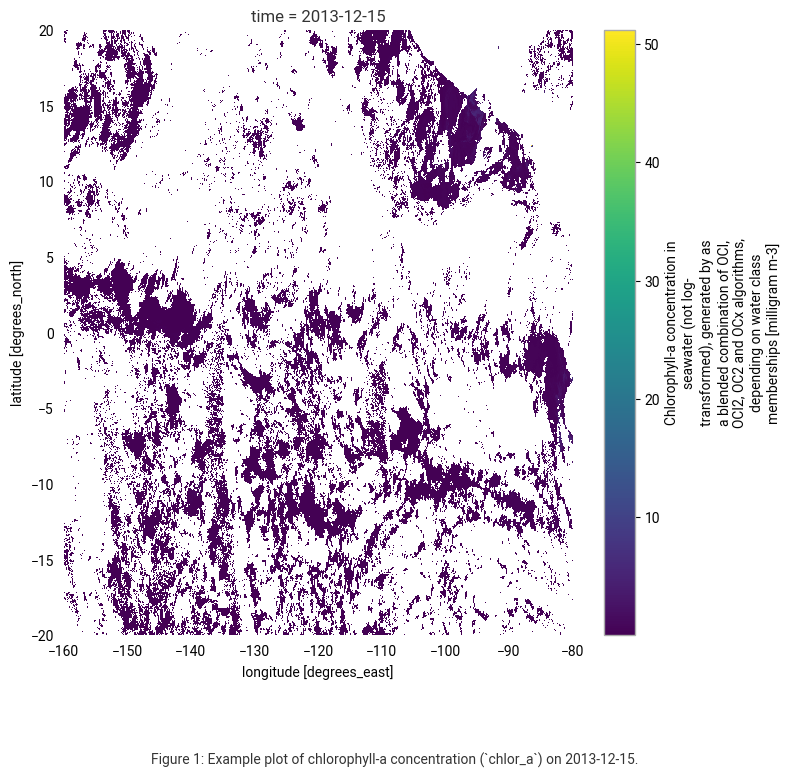

In [10]:
# Choose "chlor_a" or "analysed_sst" depending on selection from above
ds["chlor_a"].plot()

caption = (
    "Figure 1: Example plot of chlorophyll-a concentration (`chlor_a`) on 2013-12-15."
)
plt.figtext(0.5, -0.1, caption, wrap=True, horizontalalignment='center', fontsize=10)
plt.tight_layout()
plt.show()

The plot shows chlorophyll-a concentration data (not log-transformed) in milligrams per cubic meter (mg m⁻³) from the Ocean Colour dataset for December 15, 2013.<br> 
White areas indicate missing or masked data. The main reasons for these data gaps are cloud cover, sun glint, daily variability in atmospheric conditions, and gaps in satellite coverage. 

**To address these gaps, we will use monthly aggregated composites for subsequent spatial analysis.**

## Understanding Chlorophyll-a and Sea Surface Temperature during El Niño and La Niña events

In this section, we will study the **daily-temporal** and **monthly-spatial** dynamics of Chlorophyll-a and Sea Surface Temperature during the month December in an El Nino (2015) and a La Nina (1999) year compared to a "neutral" year (2013).

### Create a daily time series

In this first analysis, we will plot the daily data as time series, allowing us to observe the variations in `chlor_a` concentrations and `analysed_SST` for December across the years. <br> 

A time series analysis is essential for understanding temporal fluctuations and identifying trends that may be influenced by climatic events such as El Niño and La Niña. By examining daily variations, we can capture the timing and intensity of anomalies, as well as their persistence and recovery periods. Comparing these patterns across the specified years (1999, 2013, 2015) provides insight into how these climate events affect ocean conditions on a day-to-day basis.

To do that, we will first define a function to load and process our downloaded December data:

In [11]:
# Function to load and process December data
def load_december_data(base_path, var_name):
    data_dict = {}
    years = {"1999-12": "La Niña", "2013-12": "Neutral", "2015-12": "El Niño"}

    for year, phase in years.items():
        file_pattern = f"{base_path}/{year}/*.nc"
        files = glob.glob(file_pattern)

        if not files:
            print(f"No files found in {file_pattern}")
            continue

        ds = xr.open_mfdataset(files, combine="by_coords")
        ds = ds.sel(time=ds.time.dt.month == 12)

        # Reduce spatial dimensions (lat, lon) to a single value per time step using the mean
        ds_mean = ds[var_name].mean(dim=["lat", "lon"])

        data_dict[(int(year[: 4]), phase)] = ds_mean

    return data_dict

Now, we will load our daily data and create two time series plots using the function from above:

No files found in ./data_cds_oc/1999-12/*.nc
No files found in ./data_cds_oc/2013-12/*.nc
No files found in ./data_cds_oc/2015-12/*.nc
No files found in ./data_cds_sst/1999-12/*.nc
No files found in ./data_cds_sst/2013-12/*.nc
No files found in ./data_cds_sst/2015-12/*.nc


/var/folders/l2/529q7bzs665bnrn7_wjx1nsr0000gn/T/ipykernel_9676/264043643.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper right")
/var/folders/l2/529q7bzs665bnrn7_wjx1nsr0000gn/T/ipykernel_9676/264043643.py:40: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Roboto.
  plt.tight_layout()
/opt/homebrew/Caskroom/miniforge/base/envs/TM-TESTING/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Roboto.
  fig.canvas.print_figure(bytes_io, **kw)


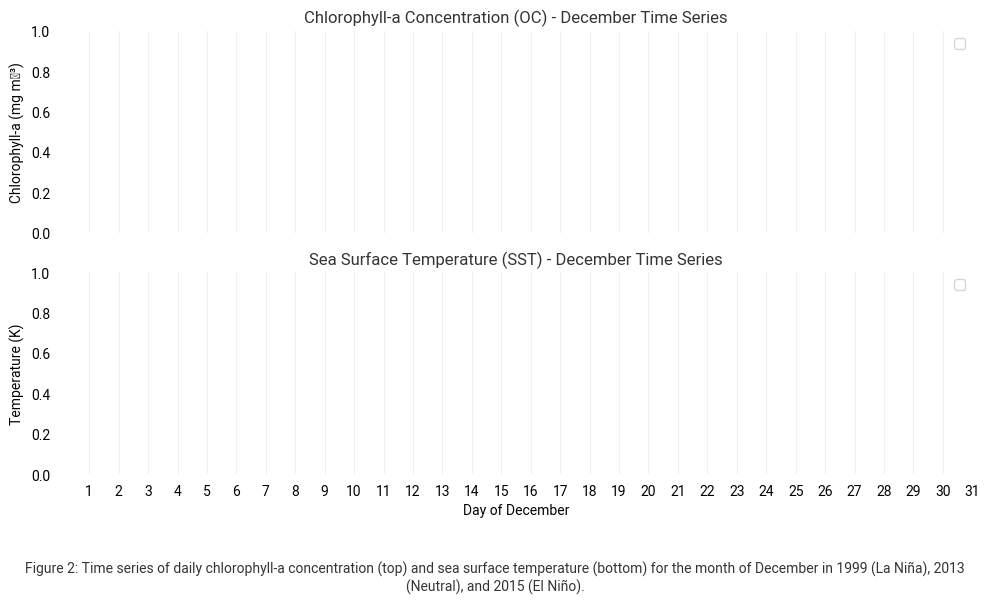

In [12]:
# Load OC (chlorophyll-a) and SST (sea surface temperature) data
oc_data = load_december_data("./data_cds_oc", "chlor_a")
sst_data = load_december_data("./data_cds_sst", "analysed_sst")

# Define colors:
oc_colors = {"1999": "green", "2013": "black", "2015": "orange"}
sst_colors = {"1999": "green", "2013": "black", "2015": "orange"}

# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Plot OC data (Chlorophyll-a)
for (year, phase), ds in oc_data.items():
    axes[0].plot(ds.time.dt.day, ds, label=f"{year} - {phase}", color=oc_colors[str(year)])

# Plot SST data (Sea Surface Temperature)
for (year, phase), ds in sst_data.items():
    axes[1].plot(ds.time.dt.day, ds, label=f"{year} - {phase}", color=sst_colors[str(year)])

# Set titles and labels
axes[0].set_title("Chlorophyll-a Concentration (OC) - December Time Series")
axes[1].set_title("Sea Surface Temperature (SST) - December Time Series")
axes[1].set_xlabel("Day of December")
axes[1].set_xticks(range(1, 32))

# Configure legends and y-axis labels
for ax in axes:
    ax.set_ylabel("Chlorophyll-a (mg m⁻³)" if ax == axes[0] else "Temperature (K)")
    ax.grid()
    ax.legend(loc="upper right")

# Add figure caption
caption = (
    "Figure 2: Time series of daily chlorophyll-a concentration (top) and sea surface temperature (bottom) "
    "for the month of December in 1999 (La Niña), 2013 (Neutral), and 2015 (El Niño)."
)
plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=10)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.20)
plt.show()

The two plots in Figure 2 display the time series of **Chlorophyll-a Concentration (OC)** and **Sea Surface Temperature (SST)** for December in different years associated with La Niña (1999), Neutral (2013), and El Niño (2015) conditions in the equatorial Pacific area that we have selected.

1. **Chlorophyll-a Concentration (Top Plot)**
   - **La Niña (1999, Green)**: Higher and more variable chlorophyll-a concentrations indicate stronger upwelling and increased nutrient availability, promoting phytoplankton growth.
   - **Neutral (2013, Black)**: Moderate concentrations.
   - **El Niño (2015, Orange)**: Lower chlorophyll-a levels suggest suppressed upwelling, leading to reduced nutrient availability and less phytoplankton activity.

2. **Sea Surface Temperature (Bottom Plot)**
   - **La Niña (1999, Green)**: Cooler SSTs align with intensified upwelling, bringing colder, nutrient-rich waters to the surface.
   - **Neutral (2013, Black)**: Intermediate SSTs.
   - **El Niño (2015, Orange)**: Warmer SSTs, typical of El Niño conditions, where upwelling is weakened due to a deeper thermocline, reducing nutrient availability and biological productivity.

This analysis confirms the typical effects of **El Niño** (warmer SSTs, lower chlorophyll) and **La Niña** (cooler SSTs, higher chlorophyll) on oceanic conditions, illustrating their significant influence on marine ecosystems.

### Analyse spatial distribution of monthly averages

In this section, we will visualise and analyse the spatial distribution of Chlorophyll-a and Sea Surface Temperature during El Niño (2015) and La Niña (1999) events compared to a "neutral" year (2013). By comparing these events to a neutral year, we can better understand how anomalous climate phenomena affect the distribution of key ocean variables, which is crucial for ecosystem management, climate modeling, and assessing the impacts of climate variability.

A spatial assessment of chlorophyll-a and sea surface temperature is crucial for understanding how these variables vary across different regions of the ocean during El Niño and La Niña events. Spatial patterns reveal localised changes in ocean productivity and thermal structure that are not evident from temporal averages alone. This approach allows us to identify regions most affected by climate anomalies, such as shifts in upwelling zones and changes in nutrient availability.

#### Aggregate daily into monthly data

We want to aggregate the daily to monthly mean datasets for each December of 1999, 2013 and 2015 to continue with the analysis of the spatial distribution of `chlor_a` and `analysed_SST` variables.

The script provided here aggregates daily data into monthly means for December of 1999, 2013, and 2015. It saves the results in new NetCDF files for further spatial analysis.

The following steps are made to get the monthly data:
1. **Define Input/Output Paths**: Specifies where to find and save the data.
2. **Ensure Directories**: Creates output directories if they don't exist.
3. **Process Data**:  
   - Loops through specified months.  
   - Loads daily data using `xarray`.  
   - Computes monthly means.
4. **Save Results**: Saves the aggregated data in NetCDF format.

In [14]:
# Define input and output paths
input_dirs = {"oc": f"{DATADIR}/oc", "sst": f"{DATADIR}/sst"}
output_dirs = {
    "oc": f"{DATADIR}/oc/monthly",
    "sst": f"{DATADIR}/sst/monthly",
}
var_names = {"oc": "chlor_a", "sst": "analysed_sst"}

# Ensure output directories exist
for out_dir in output_dirs.values():
    os.makedirs(out_dir, exist_ok=True)


def process_monthly_means(base_path, output_path, var_name):
    """Processes daily NetCDF files, calculates monthly means, and saves as new files."""
    for folder in ["1999-12", "2013-12", "2015-12"]:
        folder_path = os.path.join(base_path, folder)

        files = sorted(
            [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".nc")]
        )

        if not files:
            print(f"No files found in {folder_path}, skipping...")
            continue

        # Open multiple NetCDF files as one dataset
        ds = xr.open_mfdataset(files, combine="by_coords")

        # Compute the monthly mean
        ds_monthly = ds[var_name].resample(time="ME").mean()

        # Save the output file
        year_month = folder  # Example: "1999-12"
        output_file = os.path.join(output_path, f"{var_name}_{year_month}.nc")
        ds_monthly.to_netcdf(output_file)

        print(f"Saved: {output_file}")

# Process OC and SST data
process_monthly_means(input_dirs["oc"], output_dirs["oc"], var_names["oc"])
process_monthly_means(input_dirs["sst"], output_dirs["sst"], var_names["sst"])

Saved: ./data_dir//oc/monthly/chlor_a_1999-12.nc
Saved: ./data_dir//oc/monthly/chlor_a_2013-12.nc
Saved: ./data_dir//oc/monthly/chlor_a_2015-12.nc
Saved: ./data_dir//sst/monthly/analysed_sst_1999-12.nc
Saved: ./data_dir//sst/monthly/analysed_sst_2013-12.nc
Saved: ./data_dir//sst/monthly/analysed_sst_2015-12.nc


#### Create monthly average maps

Visualizing **monthly average Chlorophyll-a concentration** and **Sea Surface Temperature (SST)** helps to understand oceanographic conditions under different climate events like **La Niña (1999), Neutral (2013), and El Niño (2015)**. These maps provide insights into:
- Variations in **biological productivity** (by proxy of Chlorophyll-a).
- Variations in **ocean temperature** (SST).

We will create six monthly maps in one figure following these steps:
1. Load **December** data for each year.
2. Use **LogNorm** for Chlorophyll-a to account for the large dynamic range.
3. Use **consistent color scales** across years for easy comparison.
4. Arrange maps in a **3x2 grid**:
   - **Left column:** Chlorophyll-a
   - **Right column:** SST

/var/folders/l2/529q7bzs665bnrn7_wjx1nsr0000gn/T/ipykernel_9676/2355558996.py:96: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Roboto.
  plt.tight_layout()
/opt/homebrew/Caskroom/miniforge/base/envs/TM-TESTING/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Roboto.
  fig.canvas.print_figure(bytes_io, **kw)


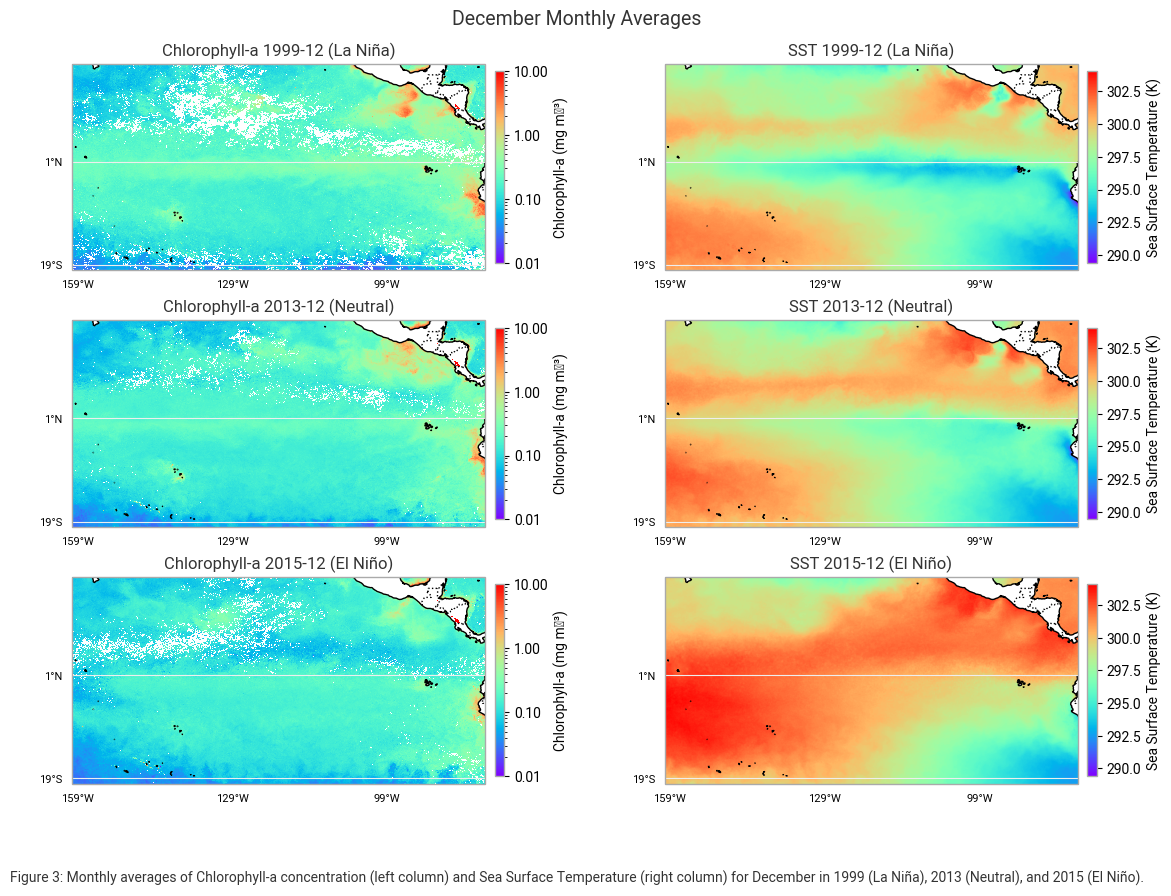

In [15]:
# Define paths to monthly data
oc_files = [
    os.path.join(DATADIR, "oc",  "monthly",f"chlor_a_{year}-12.nc")
    for year in [1999, 2013, 2015]
]
sst_files = [
    os.path.join(DATADIR, "sst", "monthly", f"analysed_sst_{year}-12.nc")
    for year in [1999, 2013, 2015]
]

# Open datasets
oc_datasets = [xr.open_dataset(f) for f in oc_files]
sst_datasets = [xr.open_dataset(f) for f in sst_files]

# Define figure and axes (3x2 grid)
fig, axes = plt.subplots(
    3, 2, figsize=(12, 9), subplot_kw={"projection": ccrs.PlateCarree()}
)
fig.suptitle("December Monthly Averages", fontsize=14)

# Function to plot data with automatic tick labeling based on dataset extent
def plot_map(ax, ds, var_name, title, cmap, norm=None):
    data = ds[var_name].squeeze()
    lat = data.lat if "lat" in data.coords else data.latitude
    lon = data.lon if "lon" in data.coords else data.longitude

    img = ax.pcolormesh(
        lon, lat, data, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm
    )
    ax.set_title(title, fontsize=12)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=":")

    # Get extent from data
    lon_min, lon_max = float(lon.min()), float(lon.max())
    lat_min, lat_max = float(lat.min()), float(lat.max())

    # Set ticks within data extent
    x_ticks = list(range(int(lon_min), int(lon_max) + 1, 30))
    y_ticks = list(range(int(lat_min), int(lat_max) + 1, 20))
    ax.set_xticks(x_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(y_ticks, crs=ccrs.PlateCarree())
    ax.tick_params(labelsize=8)
    ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
    ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)

    return img

# Define labels for each year
labels = {1999: "La Niña", 2013: "Neutral", 2015: "El Niño"}

# Define colormaps
chlorophyll_cmap = "rainbow"
sst_cmap = "rainbow"

# Define LogNorm for chlor_a
chlor_norm = LogNorm(vmin=0.01, vmax=10)

# Plot Chlorophyll-a (left column)
for i, (ds, year) in enumerate(zip(oc_datasets, [1999, 2013, 2015])):
    title = f"Chlorophyll-a {year}-12 ({labels[year]})"
    img = plot_map(
        axes[i, 0], ds, "chlor_a", title, chlorophyll_cmap, norm=chlor_norm
    )
    cbar = fig.colorbar(
        img,
        ax=axes[i, 0],
        orientation="vertical",
        fraction=0.02,
        pad=0.02,
        label="Chlorophyll-a (mg m⁻³)",
    )
    cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.2f}"))

# Determine global min/max for SST
sst_min = min(ds["analysed_sst"].min().item() for ds in sst_datasets)
sst_max = max(ds["analysed_sst"].max().item() for ds in sst_datasets)
sst_norm = Normalize(vmin=sst_min, vmax=sst_max)

# Plot SST (right column)
for i, (ds, year) in enumerate(zip(sst_datasets, [1999, 2013, 2015])):
    title = f"SST {year}-12 ({labels[year]})"
    img_sst = plot_map(
        axes[i, 1], ds, "analysed_sst", title, sst_cmap, norm=sst_norm
    )
    fig.colorbar(
        img_sst,
        ax=axes[i, 1],
        orientation="vertical",
        fraction=0.02,
        pad=0.02,
        label="Sea Surface Temperature (K)",
    )

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.92, bottom=0.12)  # Reserve space for caption

# Add figure caption (below the plots)
caption = (
    "Figure 3: Monthly averages of Chlorophyll-a concentration (left column) and Sea Surface Temperature (right column) for December "
    "in 1999 (La Niña), 2013 (Neutral), and 2015 (El Niño)."
)
plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=10)

# Show final figure
plt.show()


In December 1999, during **La Niña**, Chlorophyll-a concentrations were high along the equator and near coastal upwelling zones. The sea surface temperature (SST) was cooler, particularly along the equator, due to the intensified upwelling of deep, cold water.

In December 2013, under **neutral** conditions, Chlorophyll-a levels were intermediate and more evenly distributed across the region. The SST was moderate as ocean circulation patterns remained relatively stable.

In December 2015, during **El Niño**, Chlorophyll-a concentrations were significantly reduced in the equatorial Pacific. At the same time, SST was much warmer, with warm water spreading across the central and eastern Pacific, a hallmark of El Niño conditions.

### Create anomaly maps

In this section we will create anomaly maps. Anomaly maps are useful for identifying deviations from normal conditions, helping to visualize the impact of climate events like El Niño and La Niña. By comparing **Chlorophyll-a concentration** and **Sea Surface Temperature (SST)** for different years against a neutral reference year, we can assess how ocean conditions deviate during extreme climate events.

We will create four anomaly maps using these steps:
1. Select a **neutral year** (2013) as the baseline.
2. Compute anomalies by subtracting the neutral year's values from those of La Niña (1999) and El Niño (2015).
3. Visualize differences using a diverging colormap (e.g., **red for positive, blue for negative anomalies**).

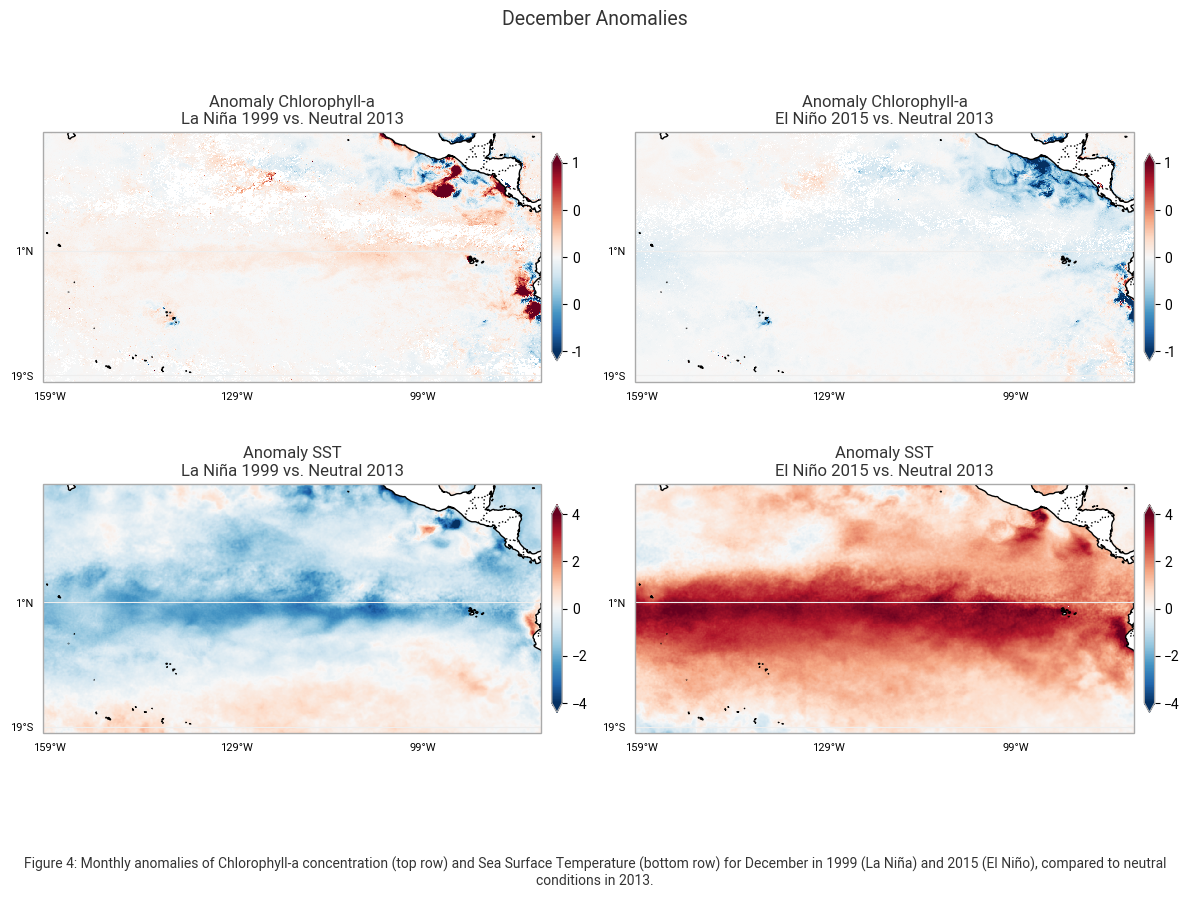

In [16]:
# Neutral data is from 2013
neutral_oc = oc_datasets[1]["chlor_a"].squeeze()
neutral_sst = sst_datasets[1]["analysed_sst"].squeeze()

# Function to calculate anomalies
def calculate_anomalies(data, neutral_data):
    return data - neutral_data

# Function to plot map with geographic ticks based on dataset extent
def plot_map(ax, data, title, cmap, norm=None):
    lat = data.lat if "lat" in data.coords else data.latitude
    lon = data.lon if "lon" in data.coords else data.longitude

    img = ax.pcolormesh(lon, lat, data, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
    ax.set_title(title, fontsize=12)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Determine tick positions based on dataset extent
    lon_min, lon_max = float(lon.min()), float(lon.max())
    lat_min, lat_max = float(lat.min()), float(lat.max())

    x_ticks = list(range(int(lon_min), int(lon_max) + 1, 30))
    y_ticks = list(range(int(lat_min), int(lat_max) + 1, 20))
    ax.set_xticks(x_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(y_ticks, crs=ccrs.PlateCarree())
    ax.tick_params(labelsize=8)
    ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
    ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)

    return img

# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(12, 9), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle("December Anomalies", fontsize=14)

# Define colormaps and normalization
chlorophyll_cmap = "RdBu_r"
sst_cmap = "RdBu_r"
chlor_norm = Normalize(vmin=-1, vmax=1)
sst_norm = Normalize(vmin=-4, vmax=4)

# Chlorophyll-a anomaly: 1999 vs 2013
oc_anomaly_1999 = calculate_anomalies(oc_datasets[0]["chlor_a"].squeeze(), neutral_oc)
img_oc_1999 = plot_map(
    axes[0, 0], oc_anomaly_1999, "Anomaly Chlorophyll-a\nLa Niña 1999 vs. Neutral 2013",
    chlorophyll_cmap, norm=chlor_norm
)
cbar_oc_1999 = fig.colorbar(
    img_oc_1999, ax=axes[0, 0], orientation="vertical",
    fraction=0.02, pad=0.02, extend="both"
)
cbar_oc_1999.ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y)}'))

# SST anomaly: 1999 vs 2013
sst_anomaly_1999 = calculate_anomalies(sst_datasets[0]["analysed_sst"].squeeze(), neutral_sst)
img_sst_1999 = plot_map(
    axes[1, 0], sst_anomaly_1999, "Anomaly SST\nLa Niña 1999 vs. Neutral 2013",
    sst_cmap, norm=sst_norm
)
fig.colorbar(
    img_sst_1999, ax=axes[1, 0], orientation="vertical",
    fraction=0.02, pad=0.02, extend="both"
)

# Chlorophyll-a anomaly: 2015 vs 2013
oc_anomaly_2015 = calculate_anomalies(oc_datasets[2]["chlor_a"].squeeze(), neutral_oc)
img_oc_2015 = plot_map(
    axes[0, 1], oc_anomaly_2015, "Anomaly Chlorophyll-a\nEl Niño 2015 vs. Neutral 2013",
    chlorophyll_cmap, norm=chlor_norm
)
cbar_oc_2015 = fig.colorbar(
    img_oc_2015, ax=axes[0, 1], orientation="vertical",
    fraction=0.02, pad=0.02, extend="both"
)
cbar_oc_2015.ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y)}'))

# SST anomaly: 2015 vs 2013
sst_anomaly_2015 = calculate_anomalies(sst_datasets[2]["analysed_sst"].squeeze(), neutral_sst)
img_sst_2015 = plot_map(
    axes[1, 1], sst_anomaly_2015, "Anomaly SST\nEl Niño 2015 vs. Neutral 2013",
    sst_cmap, norm=sst_norm
)
fig.colorbar(
    img_sst_2015, ax=axes[1, 1], orientation="vertical",
    fraction=0.02, pad=0.02, extend="both"
)

# Add figure caption
caption = (
    "Figure 4: Monthly anomalies of Chlorophyll-a concentration (top row) and Sea Surface Temperature (bottom row) for December "
    "in 1999 (La Niña) and 2015 (El Niño), compared to neutral conditions in 2013."
)
plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=10)

# Layout adjustments
plt.tight_layout()
plt.subplots_adjust(top=0.92, bottom=0.10)
plt.show()


These maps highlight the anomalies in **Chlorophyll-a concentration** (mg m-3) and **Sea Surface Temperature (SST)** (K) for December, comparing the conditions during La Niña (1999) and El Niño (2015) to the neutral year of 2013. The left column represents deviations observed during La Niña, while the right column shows anomalies associated with El Niño.

- The **Chlorophyll-a anomaly maps** in the top row reveal distinct differences in biological productivity. During **La Niña in 1999**, positive anomalies (red areas) indicate increased Chlorophyll-a concentrations, particularly along the equatorial Pacific and coastal upwelling regions. This increase is due to stronger trade winds that enhance upwelling, bringing nutrient-rich waters to the surface and supporting higher phytoplankton growth. In contrast, during **El Niño in 2015**, negative anomalies (blue areas) dominate, showing a decline in Chlorophyll-a concentrations. This reduction results from weakened upwelling and decreased nutrient availability, leading to lower biological productivity in the eastern Pacific.

- The **SST anomaly maps** in the bottom row highlight the contrasting temperature patterns associated with La Niña and El Niño. In **La Niña (1999), negative SST anomalies** (blue areas) indicate cooler-than-average sea surface temperatures, particularly in the central and eastern Pacific. These cooler temperatures are a direct result of enhanced upwelling, which brings cold, deep ocean water to the surface. In contrast, **El Niño (2015) is characterized by strong positive SST anomalies** (red areas), with temperature increases exceeding **+4°C** across the central and eastern Pacific. This warming disrupts normal oceanic circulation and weakens the upwelling process, leading to significant climate and ecosystem impacts.

These anomaly maps clearly illustrate the **opposing effects of La Niña and El Niño** on ocean temperatures and marine productivity. La Niña promotes stronger upwelling, cooler temperatures, and increased Chlorophyll-a concentrations, while El Niño leads to significant ocean warming.

## Take home messages 📌

In this notebook, we provided use cases based on Ocean Colour (variable `chlor_a`) and Sea Surface Temperature (variable `analysed_sst`) datasets to illustrate how these datasets available through the CDS can be used to study, analyze, and visualize the impacts of El Niño and La Niña events. 

- The datasets showed variations in chlorophyll-a and sea surface temperature patterns over time, with significant changes associated with major climate phenomena. 
- By comparing these patterns during El Niño and La Niña years, we can explore the relationships between these events and marine ecosystem dynamics, as well as global climate patterns
- Comparisons with other datasets can help further investigate the trends and anomalies caused by these climate events, providing insight into the broader impacts on ocean health, weather systems, and the global climate. For example, analyzing **[sea level anomaly](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-sea-level-global?tab=overview)** and **[zonal and meridional wind components](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview)** alongside ocean colour and sea surface temperature can offer a more complete picture of the physical processes driving **El Niño** and **La Niña**.